We reproduce Section 5.1 Figure 11 of our paper in this notebook, which contains the TV distance of simulating chain and cycle Ising model on IBM, IonQ, and QuEra devices (simulators and real devices). Running the exhibited code below will generate the simulator results (for free). If you want to reproduce the real device results, set the `on_simulator` variable to `False`. **CAUTION:** real device experiments may cost your money to run.

The IBM provider requires you to have an IBM account to access classical simulator (see README.md). You will be given a API token from the IBM account, and you may use the commented line to create a provider, although you may not have access to the ibmq_gradalupe device. As the time when this document is written, you may access ibmq_brisbane through the open plan of IBM. 

If you don't have an IBM account, you can remove the IBM provider and the following executions related to IBM. This merely leads to the lack of IBM (ideal) curve in the first figure.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from simuq import QSystem, Qubit
from simuq.qutip import QuTiPProvider
from simuq.braket import BraketProvider
from simuq.ionq import IonQProvider
from simuq.ibm import IBMProvider

qtpp = QuTiPProvider()
bp = BraketProvider()
ibm = IBMProvider(
    from_file="../../../qiskit_APIKEY", hub="ibm-q-ornl", group="ornl", project="phy147"
)
#ibm = IBMProvider(api_key="YOUR_API_TOKEN", hub="ibm-q", group="open", project="main")

In [2]:
def tv(P1, P2):
    keys = set(P1.keys()).union(P2.keys())
    s = 0
    for k in keys:
        if k not in P1.keys():
            s += P2[k]
        elif k not in P2.keys():
            s += P1[k]
        else:
            s += abs(P1[k] - P2[k])
    return s / 2

def ising(n, T, is_chain):
    qs = QSystem()
    qubits = [Qubit(qs) for i in range(n)]
    H = 0
    if is_chain:
        for i in range(n - 1):
            H += qubits[i].Z * qubits[(i + 1) % n].Z
    else:
        for i in range(n):
            H += qubits[i].Z * qubits[(i + 1) % n].Z
    for i in range(n):
        H += qubits[i].X
    qs.add_evolution(H, T)
    return qs

The following code runs `ising_chain` on IonQ and IBM devices (simulators) and draw the TV distance over time, reproducing the Figure 11 (left) of our paper.

In [3]:
n = 6
is_chain = True
on_simulator = True       # Set to False will send the job to real quantum device to run

dist_ionq = []
dist_ibm = []
timeslices = np.linspace(0, 1, 6)
for T in timeslices[1:]:
    qs = ising(n, T, is_chain)
    
    """Obtain ground truth by the QuTiP provider"""
    qtpp.compile(qs, verbose = -1)
    qtpp.run(verbose = -1)
    result_ideal = qtpp.results()
    
    """Obtain IonQ device results by the Braket provider"""
    bp.compile(qs, provider="ionq", device="Harmony", aais="heisenberg", tol=1, trotter_num=4, verbose=-1)
    bp.run(shots=1024, on_simulator=on_simulator, verbose=-1)
    result_ionq = bp.results()
    dist_ionq.append(tv(result_ionq, result_ideal))
    
    """Obtain IBM device results by the IBM provider"""
    ibm.compile(qs, backend="ibmq_guadalupe", trotter_num=4, use_pulse=False, verbose=-1)
    ibm.run(on_simulator=on_simulator, verbose=-1)
    result_ibm = ibm.results(on_simulator=on_simulator)
    dist_ibm.append(tv(result_ibm, result_ideal))

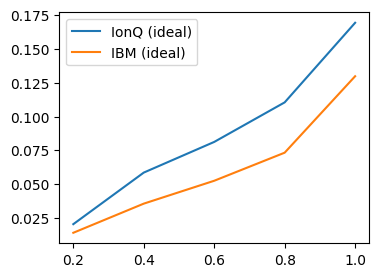

In [4]:
plt.figure(figsize=(4, 3))
plt.plot(timeslices[1:], dist_ionq, label="IonQ (ideal)")
plt.plot(timeslices[1:], dist_ibm, label="IBM (ideal)")
plt.legend()
plt.show()

The following code runs `ising_cycle` on IonQ and QuEra devices (simulators) and draw the TV distance over time, reproducing the Figure 11 (right) of our paper.

In [5]:
n = 6
is_chain = False
on_simulator = True       # Set to False will send the job to real quantum device to run

dist_ionq = []
dist_quera = []
timeslices = np.linspace(0, 1, 6)
for T in timeslices[1:]:
    qs = ising(n, T, is_chain)
    
    """Obtain ground truth by the QuTiP provider"""
    qtpp.compile(qs, verbose = -1)
    qtpp.run(verbose = -1)
    result_ideal = qtpp.results()
    
    """Obtain IonQ device results by the Braket provider"""
    bp.compile(qs, provider="ionq", device="Harmony", aais="heisenberg", tol=1, trotter_num=4, verbose=-1)
    bp.run(shots=1024, on_simulator=on_simulator, verbose=-1)
    result_ionq = bp.results()
    dist_ionq.append(tv(result_ionq, result_ideal))
    
    """Obtain QuEra device results by the Braket provider"""
    bp.compile(qs, provider="quera", device="Aquila", aais="rydberg2d_global", tol=1, verbose=-1)
    bp.run(shots=1024, on_simulator=on_simulator, verbose=-1)
    result_quera = bp.results()
    dist_quera.append(tv(result_quera, result_ideal))

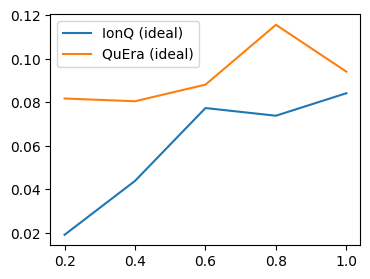

In [6]:
plt.figure(figsize=(4, 3))
plt.plot(timeslices[1:], dist_ionq, label="IonQ (ideal)")
plt.plot(timeslices[1:], dist_quera, label="QuEra (ideal)")
plt.legend()
plt.show()

These figures may seem a little different compared to the ones in our paper, mainly because of the different y-scale. The magnitudes of the data are indeed similar to our report in the paper. The real device experiment results will also fluctuate over time, since quantum devices inherently fluctuate on a daily basis.